In [137]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import datetime
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Building a corpus of concatenated conversations between users
each row in data corpus stands for a complete chat between users

In [2]:
def get_labels_dict(data_path):
    labels_dict = {}
    with open(data_path + 'sci_labels.csv', 'r') as f:
        file = csv.reader(f)
        for row in file:
            labels_dict[row[0]] = row[1]
    return labels_dict


def get_features_labels(root, labels_dict):
    corpus = [] # each row is a string formed from all messages in a conversations
    labels = [] # each row is 0 or 1, corresponds to label for same row in corpus

    for conversation in root:
        string = " "
        for message in conversation:
            text = message.find('text').text
            if text is not None:
                string = string + "\r\n" + text 
        corpus.append(string)
        labels.append(int(labels_dict[conversation.get('id')]))
    return corpus, labels

In [3]:
train_data_path = "data/pan12-sexual-predator-identification-training-corpus-2012-05-01/"

training_xml = ET.parse(train_data_path + 'training_data.xml')
train_root = training_xml.getroot()

test_data_path = 'data/pan12-sexual-predator-identification-test-corpus-2012-05-21/'
test_xml = ET.parse(test_data_path + 'pan12-sexual-predator-identification-test-corpus-2012-05-17.xml')
test_root = test_xml.getroot()

train_corpus, train_labels = get_features_labels(train_root, get_labels_dict(train_data_path))
test_corpus, test_labels = get_features_labels(test_root, get_labels_dict(test_data_path))

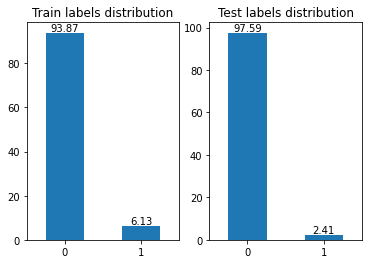

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax = (pd.Series(train_labels).value_counts()/len(train_labels)*100).round(2).plot(kind='bar',title='Train labels distribution',ax= ax1)
ax.bar_label(ax1.containers[0])
ax = (pd.Series(test_labels).value_counts()/len(test_labels)*100).round(2).plot(kind='bar',title='Test labels distribution',ax=ax2)
ax.bar_label(ax2.containers[0])
ax1.tick_params(axis='x', rotation=0)
ax2.tick_params(axis='x', rotation=0)
plt.show()

# TF-IDF on data
We will now represent all conversations using BOW with TF-IDF weighting scheme.

In [127]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)

X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(train_labels)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)

In [45]:
import lightgbm as lgb
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(X_train, y_train)
pred_y = model.predict(X_test)
print(metrics.accuracy_score(y_test, pred_y))

C:\Users\Gil zeevi\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\Gil zeevi\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\Gil zeevi\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


0.9821428571428571


In [129]:
import xgboost as xgb
model_b = xgb.XGBClassifier( eval_metric='logloss',use_label_encoder=False)
model_b.fit(X_train, y_train)
pred_y = model_b.predict(X_test)
print(metrics.accuracy_score(y_test, pred_y))

0.9851928729823114


In [130]:
best_feat = pd.Series(model_b.feature_importances_).sort_values(ascending=False).nlargest(155).index.tolist()


In [ ]:
#SVM
model = LinearSVC(random_state=0, C=2.9, loss='squared_hinge', dual=True)
model.fit(X_train, y_train)
pred_y = model.predict(X_test)
print(metrics.accuracy_score(y_test, pred_y))

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
target_names = ['Victim', 'Predator']
print(classification_report(y_test, pred_y, target_names=target_names))

In [ ]:
# linear kernel SVM 
model = svm.SVC(kernel='linear', C=1, gamma='auto', random_state=0)
model.fit(X_train, y_train)
pred_y = model.predict(X_test)
print(metrics.accuracy_score(y_test, pred_y))
print(classification_report(y_test, pred_y, target_names=target_names))

# Try PJ dataset as test set on trained corpus

In [132]:
from os import listdir
from os.path import isfile, join
import warnings
mypath = 'GeneralData'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles.remove('chatlog.dtd')


In [133]:
corpus_pj = [] # each row is a string formed from all messages in a conversations
labels_pj = [] # each row is 0 or 1, corresponds to label for same row in corpus
for file in onlyfiles:
    df= pd.read_xml(f'GeneralData/{file}').drop(columns=['COMMENT'])
    df=df[~df['BODY'].isna()]
    df=df[~df['USERNAME'].isna()]
    string = " "
    for text in df.BODY.tolist():
        if text is not None:
            string = string + "\r\n" + text 
    corpus_pj.append(string)
    labels_pj.append(1)

In [134]:
X_test_pj = vectorizer.transform(corpus_pj)
X_test_pj = scipy.sparse.csr_matrix(X_test_pj)[:,best_feat]
y_test_pj = np.array(labels_pj)

In [136]:
pred_y = model.predict(X_test_pj)
print(metrics.accuracy_score(y_test_pj, pred_y))
np.unique(pred_y,return_counts=True)
#55/1 with lightGBM

0.9642857142857143


(array([0, 1]), array([ 2, 54], dtype=int64))